In [1]:
import itertools
import os

import joblib
import numpy as np
import pandas as pd
import torch

import time

import matplotlib.pyplot as plt
from pandas import DataFrame

from sklearn.model_selection import train_test_split

from models.base_regressor import BaseRegressor
import training as methods

In [10]:
####################
# LOADING THE DATA #
####################
DATA_DIR = "../segmented_data/"

SUBJECTS = ['AT', 'RB', 'RL']
SCENES = ['FlatWalkStraight']
TRIALS = ('all')

def read_gait_cycles(subjects, scenes, trials):
    # Adds the features of several past and future timesteps to each row
    def expand_timeframe(gait_cycle):
        NR_OF_TIMESTEPS = 6
        past   = [ 2**i for i in range(NR_OF_TIMESTEPS)]
        future = [-2**i for i in range(NR_OF_TIMESTEPS)]
        for offset in past + future:
            # Shift the relevant columns back/forwards in time
            columns = [col for col in methods.INPUTS if not col.startswith('P')]
            shifted = gait_cycle[columns].shift(offset)
            # Rename shifted columns and concat to gait_cycle
            timestep = offset * -2 # ms
            shifted.columns = [f'{col}_{timestep}ms' for col in columns]
            gait_cycle = pd.concat([gait_cycle, shifted], axis=1)
        return gait_cycle
    
    # Removes the first and final (25) rows for which no target label is available
    def remove_buffers(df):
        cond = df.iloc[:, 0:8].sum(axis=1) != 0
        first = df[cond].index[0]
        last = df[cond].index[-1] + 1
        return df[first:last]
    
    # Reads a single csv-file, expands the features and removes the buffers
    def read_gait_cycle(filepath):
        gait_cycle = pd.read_csv(filepath, header=0, names=methods.HEADER)
        gait_cycle = expand_timeframe(gait_cycle)
        return remove_buffers(gait_cycle)
    
    # Build up DataFrame of gait cyles by traversing the specified TRIALS
    df = DataFrame()
    for subdirs in itertools.product(subjects, scenes):
        path = DATA_DIR + '/'.join(subdirs)
        for file in os.listdir(path):
            if file.endswith('.csv') and (file.startswith(trials) or trials == ('all')):
                print("Reading", file)
                filepath = path + '/' + file
                gait_cycle = read_gait_cycle(filepath)
                gait_cycle['trial'] = file
                gait_cycle['subject'] = subdirs[0]
                df = pd.concat([df, gait_cycle])
    return df


gait_cycles = read_gait_cycles(SUBJECTS, SCENES, TRIALS)

Reading BW jogging_1.csv
Reading BW jogging_2.csv
Reading BW jogging_3.csv
Reading BW jogging_4_badStep.csv
Reading BW jogging_5.csv
Reading BW jogging_6_badForcePlate.csv
Reading BW jogging_7.csv
Reading BW jogging_8.csv
Reading Bw stop FW walking_1.csv
Reading Bw stop FW walking_2.csv
Reading Bw stop FW walking_3.csv
Reading Bw stop FW walking_4.csv
Reading Bw stop FW walking_5.csv
Reading Bw stop FW walking_6.csv
Reading Bw stop FW walking_7.csv
Reading BW walking_1_badForcePlate.csv
Reading BW walking_2.csv
Reading BW walking_4.csv
Reading BW walking_5.csv
Reading BW walking_6_badForcePlate.csv
Reading BW walking_7_badForcePlate.csv
Reading BW walking_8.csv
Reading BW-L walking_1.csv
Reading BW-L walking_2_badForcePlate.csv
Reading BW-L walking_3.csv
Reading BW-L walking_4_badForcePlate.csv
Reading BW-L walking_5_badForcePlate.csv
Reading BW-R walking_1_badForcePlate.csv
Reading BW-R walking_2.csv
Reading BW-R walking_3.csv
Reading BW-R walking_4.csv
Reading BW-R walking_5.csv
Read

In [11]:
###################
# BASE-META SPLIT #
###################
df_base, df_meta = train_test_split(gait_cycles, test_size=0.5, random_state=42, stratify=gait_cycles['trial'])

In [12]:
##############################################
# LEFT VS. RIGHT FOOT -> MAIN VS. OTHER FOOT #
##############################################
def homogenize(df):
    def rename_columns(df, main_foot, other_foot):
        mapping = {col: col.replace("_" + main_foot, "")
                           .replace("_" + other_foot, "_o")
                   for col in df.columns}
        return df.rename(columns=mapping)
    # Create the new DataFrame
    df_l = rename_columns(df, 'l', 'r')
    df_r = rename_columns(df, 'r', 'l')
    df_r = df_r[df_l.columns]
    return df_l, df_r

df_l, df_r = homogenize(df_base)
df_homogenous = pd.concat([df_l, df_r])

In [13]:
#############
# FILTERING #
#############
df_filtered = methods.filter(df_homogenous)

df_filtered.groupby(['trial']).count()

,Fx,Fy,Fz,M,Fx_o,Fy_o,Fz_o,M_o,Ftot,CoPx,...,angz_o_64ms,vm_o_64ms,vm_64ms,vr_o_64ms,vr_64ms,gm_o_64ms,gm_64ms,tfl_o_64ms,tfl_64ms,subject
trial,,,,,,,,,,,,,,,,,,,,,
BW jogging_1.csv,108,108,108,108,108,108,108,108,108,108,...,108,108,108,108,108,108,108,108,108,108
BW jogging_2.csv,113,113,113,113,113,113,113,113,113,113,...,113,113,113,113,113,113,113,113,113,113
BW jogging_3.csv,56,56,56,56,56,56,56,56,56,56,...,56,56,56,56,56,56,56,56,56,56
BW jogging_3_badForcePlate.csv,53,53,53,53,53,53,53,53,53,53,...,53,53,53,53,53,53,53,53,53,53
BW jogging_4.csv,89,89,89,89,89,89,89,89,89,89,...,89,89,89,89,89,89,89,89,89,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sidestepping normal_5.csv,435,435,435,435,435,435,435,435,435,435,...,435,435,435,435,435,435,435,435,435,435
Sidestepping normal_6.csv,309,309,309,309,309,309,309,309,309,309,...,309,309,309,309,309,309,309,309,309,309
Sidestepping normal_7.csv,134,134,134,134,134,134,134,134,134,134,...,134,134,134,134,134,134,134,134,134,134


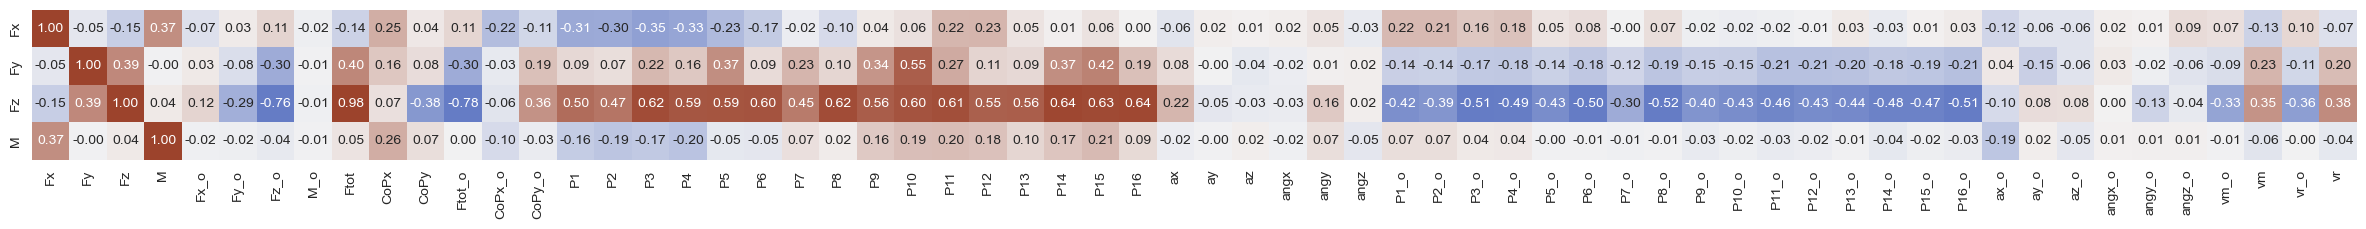

In [14]:
import seaborn as sns

plt.figure(figsize=(30, 10))
corr = df_filtered.iloc[:, :62].corr()
corr_dep = corr.iloc[0:4]
cmap = sns.diverging_palette(260, 20, s=75, l=40, n=5, center="light", as_cmap=True)
sns.heatmap(corr_dep, cmap=cmap, center=0, annot=True, fmt='.2f', square=True, robust=True, cbar=False)

plt.show()

In [15]:
####################
# TRAIN-TEST SPLIT #
####################
df_full_train, df_test = train_test_split(df_filtered, test_size=0.2, random_state=42, stratify=df_filtered['trial'])

In [16]:
############################
# FEATURE/LABEL EXTRACTION #
############################
# Features
X_full_train = methods.extract_features(df_full_train)
X_test = methods.extract_features(df_test)

print('X_full_train:', np.shape(X_full_train))

# Labels
Fx_full_train = df_full_train['Fx']
Fy_full_train = df_full_train['Fy']
Fz_full_train = df_full_train['Fz']
M_full_train  = df_full_train['M']
Fx_test = df_test['Fx']
Fy_test = df_test['Fy']
Fz_test = df_test['Fz']
M_test  = df_test['M']

print('Fx_full_train:', np.shape(Fx_full_train))

# Partitions
partition_full_train = df_full_train['trial']
partition_test = df_test['trial']

print('partition_full_train:', np.shape(partition_full_train))

X_full_train: (16596, 338)
Fx_full_train: (16596,)
partition_full_train: (16596,)


In [17]:
DIR = '../results/' + time.strftime("%Y%m%d-%H%M%S/", time.localtime())

###############
# PERFORM PCA #
###############
X_pc_full_train, X_pc_test = methods.perform_pca(X_full_train, X_test, DIR)
nr_of_features = np.shape(X_pc_full_train)[1]

Number of features before PCA 338
Number of features after PCA 148


In [18]:
######################
# CONVERT TO TENSORS #
######################
# Features
X_full_train_tensor = torch.tensor(X_pc_full_train, dtype=torch.float32)
X_test_tensor       = torch.tensor(X_pc_test, dtype=torch.float32)

# Labels
Fx_full_train_tensor = torch.tensor(Fx_full_train.to_numpy().reshape((-1, 1)), dtype=torch.float32)
Fy_full_train_tensor = torch.tensor(Fy_full_train.to_numpy().reshape((-1, 1)), dtype=torch.float32)
Fz_full_train_tensor = torch.tensor(Fz_full_train.to_numpy().reshape((-1, 1)), dtype=torch.float32)
M_full_train_tensor  = torch.tensor(M_full_train.to_numpy().reshape((-1, 1)), dtype=torch.float32)
Fx_test_tensor = torch.tensor(Fx_test.to_numpy().reshape((-1, 1)), dtype=torch.float32)
Fy_test_tensor = torch.tensor(Fy_test.to_numpy().reshape((-1, 1)), dtype=torch.float32)
Fz_test_tensor = torch.tensor(Fz_test.to_numpy().reshape((-1, 1)), dtype=torch.float32)
M_test_tensor  = torch.tensor(M_test.to_numpy().reshape((-1, 1)), dtype=torch.float32)

Performance on the test set:
NRMSE = 0.0832
r = 0.8680903656003899


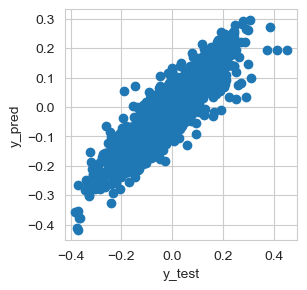

In [19]:
################
# Fx REGRESSOR #
################
Fx_regressor = BaseRegressor(nr_of_features, [42])
Fx_regressor.train_(X_full_train_tensor, Fx_full_train_tensor)

# Evaluate the model
Fx_regressor.eval()
Fx_pred_tensor = Fx_regressor(X_test_tensor)
methods.print_metrics(Fx_test_tensor, Fx_pred_tensor)

Fx_regressor.save(DIR, 'Fx_base')

Performance on the test set:
NRMSE = 0.0819
r = 0.8736174400004658


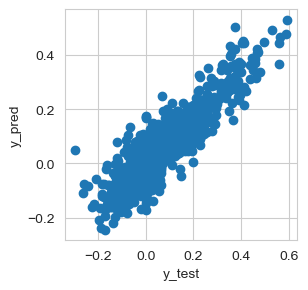

In [20]:
################
# Fy REGRESSOR #
################
Fy_regressor = BaseRegressor(nr_of_features, [42])
Fy_regressor.train_(X_full_train_tensor, Fy_full_train_tensor)

# Evaluate the model
Fy_regressor.eval()
Fy_pred_tensor = Fy_regressor(X_test_tensor)
methods.print_metrics(Fy_test_tensor, Fy_pred_tensor)

Fy_regressor.save(DIR, 'Fy_base')

Performance on the test set:
NRMSE = 0.0517
r = 0.9831066464054539


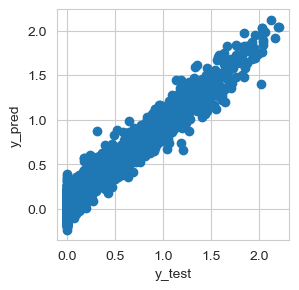

In [21]:
################
# Fz REGRESSOR #
################
Fz_regressor = BaseRegressor(nr_of_features, [42])
Fz_regressor.train_(X_full_train_tensor, Fz_full_train_tensor)

# Evaluate the model
Fz_regressor.eval()
Fz_pred_tensor = Fz_regressor(X_test_tensor)
methods.print_metrics(Fz_test_tensor, Fz_pred_tensor)

Fz_regressor.save(DIR, 'Fz_base')

Performance on the test set:
NRMSE = 0.1451
r = 0.5850797459931337


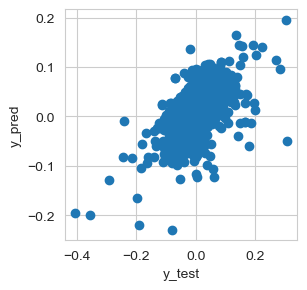

In [22]:
###############
# M REGRESSOR #
###############
M_regressor = BaseRegressor(nr_of_features, [50])
M_regressor.train_(X_full_train_tensor, M_full_train_tensor)

# Evaluate the model
M_regressor.eval()
M_pred_tensor = M_regressor(X_test_tensor)
methods.print_metrics(M_test_tensor, M_pred_tensor)

M_regressor.save(DIR, 'M_base')

In [24]:
#############################
# SPLIT LEFT AND RIGHT FOOT #
#############################
# Remove rows with non-available values
df_meta = df_meta.dropna()
df_l, df_r = homogenize(df_meta)

In [25]:
############################
# FEATURE/LABEL EXTRACTION #
############################
# Features
X_l = methods.extract_features(df_l)
X_r = methods.extract_features(df_r)

print('X_l:', np.shape(X_l))

# Labels
Y_l = df_l[['Fx', 'Fy', 'Fz', 'M']]
Y_r = df_r[['Fx', 'Fy', 'Fz', 'M']]

print('Y_l:', np.shape(Y_l))

# Partition
partition_l = df_l['trial']
partition_r = df_r['trial']

print('partition_l:', np.shape(partition_l))

X_l: (12377, 338)
Y_l: (12377, 4)
partition_l: (12377,)


In [26]:
###############
# PERFORM PCA #
###############
pca = joblib.load(DIR + 'PCA.pkl')

X_l_pc = pca.transform(X_l)
X_r_pc = pca.transform(X_r)

np.shape(X_l_pc)

(12377, 148)

In [27]:
######################
# CONVERT TO TENSORS #
######################
# Features
X_l_pc_tensor = torch.tensor(X_l_pc, dtype=torch.float32)
X_r_pc_tensor = torch.tensor(X_r_pc, dtype=torch.float32)

In [28]:
##################################
# MAKING THE INITIAL PREDICTIONS #
##################################
Fx_l_pred = Fx_regressor(X_l_pc_tensor)
Fy_l_pred = Fy_regressor(X_l_pc_tensor)
Fz_l_pred = Fz_regressor(X_l_pc_tensor)
M_l_pred  = M_regressor(X_l_pc_tensor)

Fx_r_pred = Fx_regressor(X_r_pc_tensor)
Fy_r_pred = Fy_regressor(X_r_pc_tensor)
Fz_r_pred = Fz_regressor(X_r_pc_tensor)
M_r_pred  = M_regressor(X_r_pc_tensor)

In [29]:
###############################################
# CREATING THE INPUT DATA FOR THE META MODELS #
###############################################
# Add inital predictions to input
X_l_tensor = torch.cat((X_l_pc_tensor, Fx_l_pred, Fy_l_pred, Fz_l_pred, M_l_pred, Fx_r_pred, Fy_r_pred, Fz_r_pred, M_r_pred), dim=1)
X_r_tensor = torch.cat((X_r_pc_tensor, Fx_l_pred, Fy_l_pred, Fz_l_pred, M_l_pred, Fx_r_pred, Fy_r_pred, Fz_r_pred, M_r_pred), dim=1)

nr_of_features = np.shape(X_l_tensor)[1]

nr_of_features

156

In [30]:
#############
# FILTERING #
#############
def filter(X_tensor, Y_df, partition, df):
    mask = ((df['fp1'] != 1)
            & (df['valid_mask_feet'] == 1)
            & (df['correct_mask_ins'] == 1)
            & ((df['Ftot'] < 0.05) | (df['Fz'] != 0))).values
    
    return X_tensor[mask], Y_df[mask], partition[mask]

X_l_filtered_tensor, Y_l_filtered, partition_l_filtered = filter(X_l_tensor, Y_l, partition_l, df_l)
X_r_filtered_tensor, Y_r_filtered, partition_r_filtered = filter(X_r_tensor, Y_r, partition_r, df_r)

print(np.shape(X_l_filtered_tensor))
print(np.shape(Y_l_filtered))

# Concat left and right foot
X_filtered_tensor = torch.cat((X_l_filtered_tensor, X_r_filtered_tensor), dim=0)
Y_filtered = pd.concat([Y_l_filtered, Y_r_filtered], axis=0)
partition_filtered = pd.concat([partition_l_filtered, partition_r_filtered], axis=0)

print(np.shape(X_filtered_tensor))
print(np.shape(Y_filtered))
print(np.shape(partition_filtered))

torch.Size([10428, 156])
(10428, 4)
torch.Size([20829, 156])
(20829, 4)
(20829,)


In [31]:
####################
# TRAIN-TEST SPLIT #
####################
X_full_train, X_test, Y_full_train, Y_test = train_test_split(X_filtered_tensor.detach().numpy(), Y_filtered, test_size=0.2, random_state=42, stratify=partition_filtered)

In [32]:
######################
# CONVERT TO TENSORS #
######################
# Features
X_full_train_tensor = torch.tensor(X_full_train, dtype=torch.float32)
X_test_tensor       = torch.tensor(X_test, dtype=torch.float32)

# Labels
Fx_full_train_tensor = torch.tensor(Y_full_train['Fx'].to_numpy().reshape((-1, 1)), dtype=torch.float32)
Fy_full_train_tensor = torch.tensor(Y_full_train['Fy'].to_numpy().reshape((-1, 1)), dtype=torch.float32)
Fz_full_train_tensor = torch.tensor(Y_full_train['Fz'].to_numpy().reshape((-1, 1)), dtype=torch.float32)
M_full_train_tensor  = torch.tensor(Y_full_train['M'].to_numpy().reshape((-1, 1)), dtype=torch.float32)
Fx_test_tensor = torch.tensor(Y_test['Fx'].to_numpy().reshape((-1, 1)), dtype=torch.float32)
Fy_test_tensor = torch.tensor(Y_test['Fy'].to_numpy().reshape((-1, 1)), dtype=torch.float32)
Fz_test_tensor = torch.tensor(Y_test['Fz'].to_numpy().reshape((-1, 1)), dtype=torch.float32)
M_test_tensor  = torch.tensor(Y_test['M'].to_numpy().reshape((-1, 1)), dtype=torch.float32)

Performance on the test set:
NRMSE = 0.0772
r = 0.8793717630735977


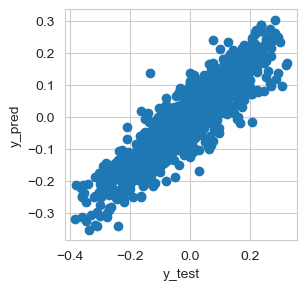

In [33]:
#################
# Fx META-MODEL #
#################
Fx_meta = BaseRegressor(nr_of_features, [42])
Fx_meta.train_(X_full_train_tensor, Fx_full_train_tensor)

# Evaluate the model
Fx_meta.eval()
Fx_pred_tensor = Fx_meta(X_test_tensor)
methods.print_metrics(Fx_test_tensor, Fx_pred_tensor)

Fx_meta.save(DIR, 'Fx_meta')

Performance on the test set:
NRMSE = 0.0698
r = 0.9030515395073885


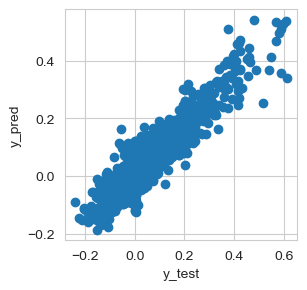

In [34]:
#################
# Fy META-MODEL #
#################
Fy_meta = BaseRegressor(nr_of_features, [42])
Fy_meta.train_(X_full_train_tensor, Fy_full_train_tensor)

# Evaluate the model
Fy_meta.eval()
Fy_pred_tensor = Fy_meta(X_test_tensor)
methods.print_metrics(Fy_test_tensor, Fy_pred_tensor)

Fy_meta.save(DIR, 'Fy_meta')

Performance on the test set:
NRMSE = 0.0494
r = 0.9850085825839224


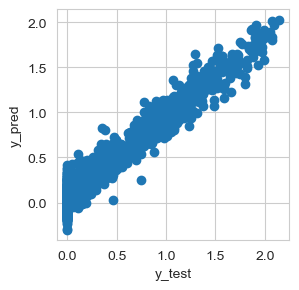

In [35]:
#################
# Fz META-MODEL #
#################
Fz_meta = BaseRegressor(nr_of_features, [42])
Fz_meta.train_(X_full_train_tensor, Fz_full_train_tensor)

# Evaluate the model
Fz_meta.eval()
Fz_pred_tensor = Fz_meta(X_test_tensor)
methods.print_metrics(Fz_test_tensor, Fz_pred_tensor)

Fz_meta.save(DIR, 'Fz_meta')

Performance on the test set:
NRMSE = 0.1370
r = 0.6016856299036315


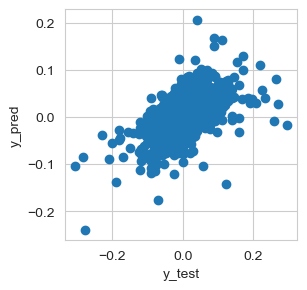

In [36]:
################
# M META-MODEL #
################
M_meta = BaseRegressor(nr_of_features, [42])
M_meta.train_(X_full_train_tensor, M_full_train_tensor)

# Evaluate the model
M_meta.eval()
M_pred_tensor = M_meta(X_test_tensor)
methods.print_metrics(M_test_tensor, M_pred_tensor)

M_meta.save(DIR, 'M_meta')